# Overview

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

- As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. 
- In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

# Data

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- userid - a unique number that identifies each player.
- version - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- sum_gamerounds - the number of game rounds played by the player during the first week after installation
- retention_1 - did the player come back and play 1 day after installing?
- retention_7 - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40

# AB Testing Process

- Understanding business problem & data
- Detect and resolve problems in the data (Missing Value, Outliers, Unexpected Value)
- Look summary stats and plots
- Apply hypothesis testing and check assumptions
- Check Normality & Homogeneity
- Apply tests (Shapiro, Levene Test, T-Test, Welch Test, Mann Whitney U Test)
- Evaluate the results
- Make inferences
- Recommend business decision to your customer/director/ceo etc.

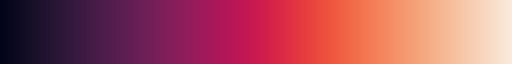

In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats as st
import statsmodels.api as sms
sns.color_palette("rocket", as_cmap=True)

In [2]:
df = pd.read_csv('cookie_cats.csv')

In [3]:
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


### Нет пропусков, все user_id уникальны

In [5]:
df.groupby('version')['version'].count()

version
gate_30    44700
gate_40    45489
Name: version, dtype: int64

### Группы примерно равного размера

In [6]:
control = df[df['version'] == 'gate_30'][['sum_gamerounds', 'retention_1', 'retention_7']].reset_index(drop=True)
test = df[df['version'] == 'gate_40'][['sum_gamerounds', 'retention_1', 'retention_7']].reset_index(drop=True)

In [7]:
control['sum_gamerounds'].describe()

count    44700.000000
mean        52.456264
std        256.716423
min          0.000000
25%          5.000000
50%         17.000000
75%         50.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64

In [8]:
test['sum_gamerounds'].describe()

count    45489.000000
mean        51.298776
std        103.294416
min          0.000000
25%          5.000000
50%         16.000000
75%         52.000000
max       2640.000000
Name: sum_gamerounds, dtype: float64

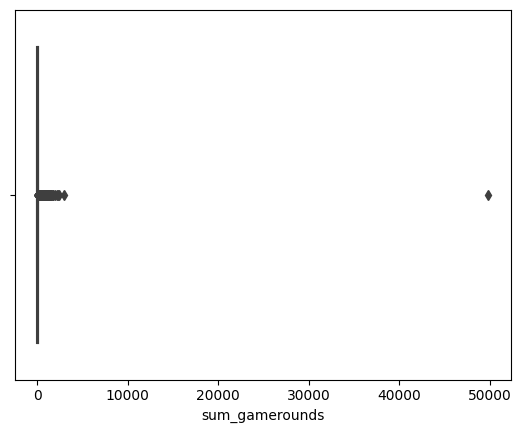

In [9]:
_ = sns.boxplot(x = control['sum_gamerounds'])

### Есть один выброс, удалим

In [10]:
control = control[control['sum_gamerounds'] != 49854]

<AxesSubplot:xlabel='sum_gamerounds', ylabel='version'>

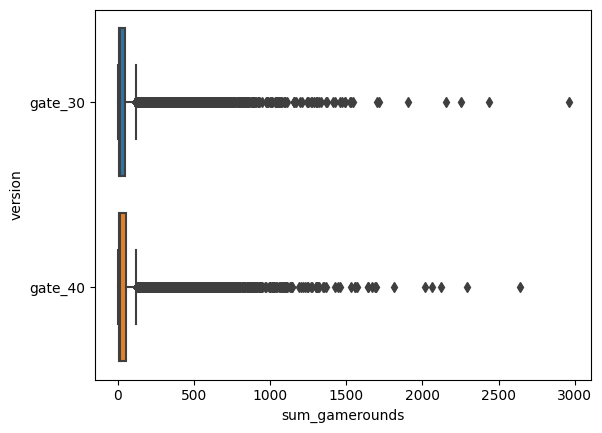

In [11]:
d = {
    'control': control['sum_gamerounds'],
    'test': test['sum_gamerounds']
}
d = pd.DataFrame(d)
sns.boxplot(data = df[df['sum_gamerounds'] != 49854], x = 'sum_gamerounds', y = 'version')

### Посмотрм тесты

In [12]:
print(f'means in control {np.mean(control["retention_1"])}, {np.mean(control["retention_7"])}, {np.mean(control["sum_gamerounds"])}')
print(f'means in test {np.mean(test["retention_1"])}, {np.mean(test["retention_7"])}, {np.mean(test["sum_gamerounds"])}')

means in control 0.4481979462627799, 0.19018322557551623, 51.342110561757536
means in test 0.44228274967574577, 0.18200004396667327, 51.29877552814966


In [13]:
cj_table = [[[control[retention].sum(), control[retention].count() - control[retention].sum()],
             [test[retention].sum(), test[retention].count() - test[retention].sum()]] for retention in ['retention_1', 'retention_7']]
dict_cj_table = dict(zip(['retention_1', 'retention_7'], cj_table))

for feat in ['sum_gamerounds', 'retention_1', 'retention_7']:
    if feat == 'sum_gamerounds':
        print(f'for {feat}\n{st.ttest_ind(control[feat], test[feat])}\n{st.mannwhitneyu(control[feat], test[feat])}\n')
    else:
        print(f'for {feat}\n{st.ttest_ind(control[feat], test[feat])}\n{st.mannwhitneyu(control[feat], test[feat])}\nCh2Result{st.chi2_contingency(observed =dict_cj_table[feat], correction=True)[0:2]}\n')

for sum_gamerounds
Ttest_indResult(statistic=0.0633675766982082, pvalue=0.9494739458256001)
MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

for retention_1
Ttest_indResult(statistic=1.7871153372992439, pvalue=0.07392220630182522)
MannwhitneyuResult(statistic=1022670128.0, pvalue=0.073922385401239)
Ch2Result(3.169835543170799, 0.07500999897705693)

for retention_7
Ttest_indResult(statistic=3.1575495965685936, pvalue=0.0015915357297854773)
MannwhitneyuResult(statistic=1024975889.5, pvalue=0.0015918697815176374)
Ch2Result(9.915275528905669, 0.0016391259678654423)



### Статзначимо отличается только ретеншн за 7 дней, причем в меньшую сторону

## log ttest

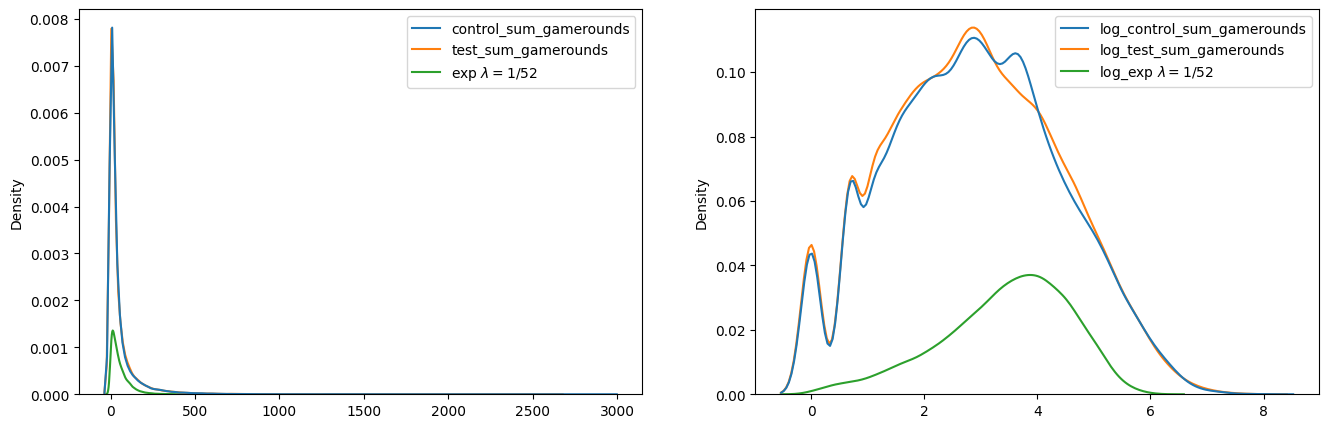

In [14]:
np.random.seed(42)
d1 = {
    'log_control_sum_gamerounds': np.log(control['sum_gamerounds'] + 1),
    'log_test_sum_gamerounds': np.log(test['sum_gamerounds'] + 1),
    r'log_exp $\lambda = 1/52$': np.log1p(np.random.exponential(52, size = 10000))
}

d2 = {
    'control_sum_gamerounds': control['sum_gamerounds'],
    'test_sum_gamerounds': test['sum_gamerounds'],
    r'exp $\lambda = 1/52$': np.random.exponential(52, size = 10000)
}

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 5))
ax = sns.kdeplot(d2, ax=ax1)
ax = sns.kdeplot(d1, ax=ax2)

### Слева похоже на экспоненциальное

In [15]:
st.ttest_ind(np.log(control['sum_gamerounds'] + 0.01), np.log(test['sum_gamerounds'] + 0.01))

Ttest_indResult(statistic=1.9801370270745746, pvalue=0.04769116789151832)

In [16]:
st.ttest_ind(np.log1p(control['sum_gamerounds']), np.log1p(test['sum_gamerounds']))

Ttest_indResult(statistic=1.7966779505411907, pvalue=0.07239010632765697)

### В зависимости от смещения в логарифме разные результаты :\

In [17]:
st.kstest(np.log1p(control['sum_gamerounds']), np.log1p(test['sum_gamerounds']))

KstestResult(statistic=0.010258010418840668, pvalue=0.01727609923280408)

In [18]:
st.kstest(control['sum_gamerounds'], test['sum_gamerounds'])

KstestResult(statistic=0.010258010418840668, pvalue=0.01727609923280408)

### ks-test говорит непохожи

In [19]:
log_smg = np.log1p(control['sum_gamerounds'] )

In [20]:
st.shapiro(log_smg[:4999])

ShapiroResult(statistic=0.9869834184646606, pvalue=4.453146618621615e-21)

In [21]:
st.kstest((log_smg - log_smg.mean())/log_smg.std(), st.norm.rvs(loc= 0, scale = 1, size = 10000))

KstestResult(statistic=0.0407549766214009, pvalue=3.1293685642384816e-12)

### Нормальности нет

<AxesSubplot:>

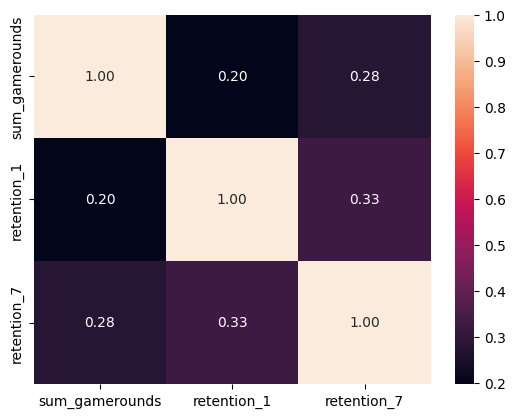

In [22]:
sns.heatmap(df[['sum_gamerounds', 'retention_1', 'retention_7']].corr(), annot=True, fmt=".2f")

### Везде слабая линейная зависимоость 

#### Любим халяву, приходят уведомления

## Bayes

#### Тут мы строим апостериорное распределение для параметра $p$ вероятности конверсии после наблюдения $X$ $f(p|X) = \dfrac{f_{ML}(X|p)f(p)}{\int_0^1f_{ML}(X|p)f(p)}$.
- Где $X=(X_1, X_2,...,X_n)$ наша выборка, пусть в нашей выборке m - количество успехов.
- $f_{ML}(X|p)=p^{m}(1-p)^{n-m}$ это функция максимального правдоподобия от нашей выборки при параметре $p$. 
- Тогда $f(p|X)=\dfrac{p^{m}(1-p)^{n-m}}{B(m + 1, n-m +1)} \sim Beta(m+1, n-m+1)$.

Полученное распределение можно интерпретировать как степень уверенности о значении параметра при данной выборке

“there is a 95% probability that when computing a confidence interval from data of this sort, the effect falls within this range”

“given the observed data, the effect has 95% probability of falling within this range”

#### Есть три критерия выбора
- PP2B - probability to be best $P(p_B > p_A|X) > someprobability$
- Credible interval $CI(p_B-p_A)$
- Expected loss

0.0383 -0.01307525100799733


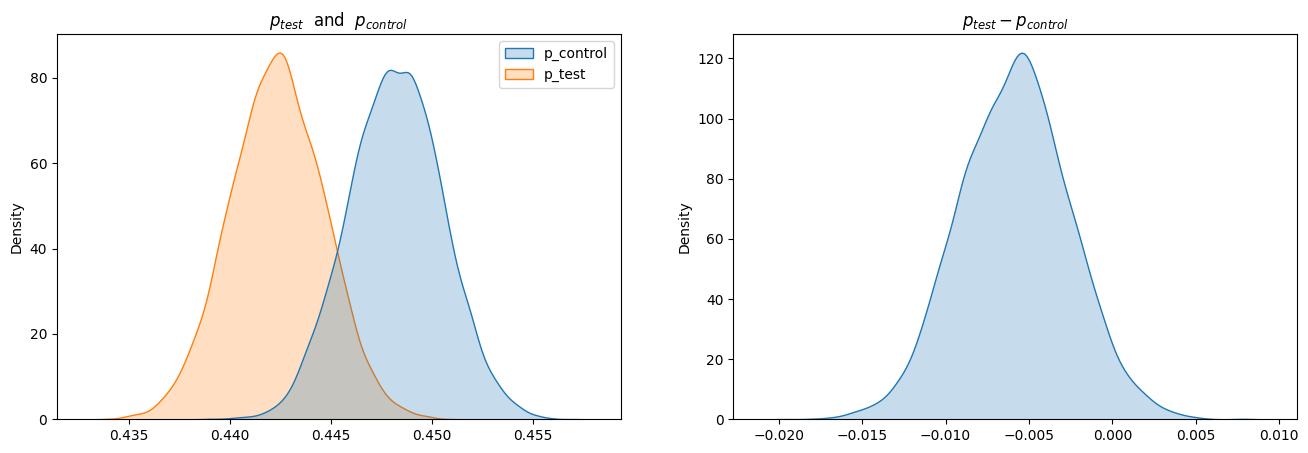

In [23]:
np.random.seed(42)

control_p = st.beta(1 + control['retention_1'].sum(), 1 + (control['retention_1'].count() - control['retention_1'].sum())).rvs(10000)
test_p = st.beta(1 + test['retention_1'].sum(), 1 + (test['retention_1'].count() - test['retention_1'].sum())).rvs(10000)

fg = {
    'p_control': control_p,
    'p_test': test_p
}

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 5))
_ = sns.kdeplot(fg, fill=True, ax=ax1).set_title(r'$p_{test}$  and  $p_{control}$')

_ = sns.kdeplot(test_p - control_p, fill=True, ax=ax2).set_title(r'$p_{test}-p_{control}$')
print(np.mean(control_p < test_p), np.mean((test_p - control_p) / control_p))

$P(p_A,p_B|d)$ :


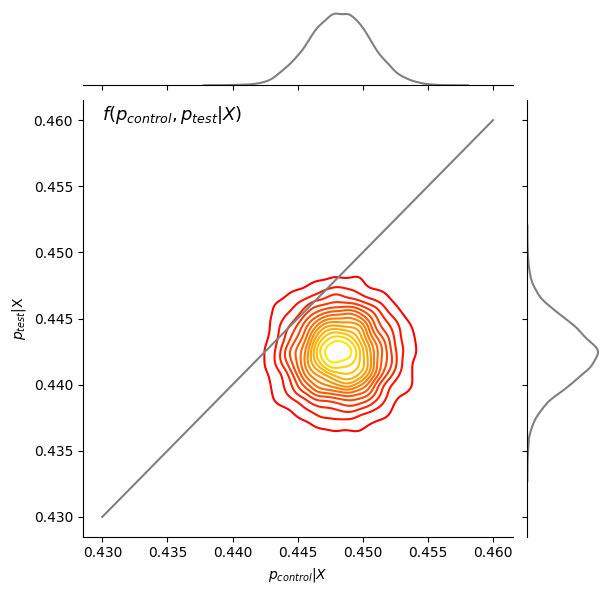

$P(p_A,p_B|d)$ :


In [24]:
vals=np.vstack([control_p, test_p]).T
print(r'$P(p_A,p_B|d)$ :')
ct=pd.DataFrame(vals, columns=['Control', 'Test'])
g=sns.jointplot(x=ct.Control, y=ct.Test, kind='kde', n_levels=15, color="grey", cmap="autumn")
g.ax_joint.plot([0.43, 0.46], [0.43, 0.46], color="grey")
plt.xlabel(r'$p_{control}|X$')
plt.ylabel(r'$p_{test}$|X')
plt.text(0.430, 0.460, r'$f(p_{control}, p_{test}|X)$', fontsize=13)
plt.show()
print(r'$P(p_A,p_B|d)$ :')

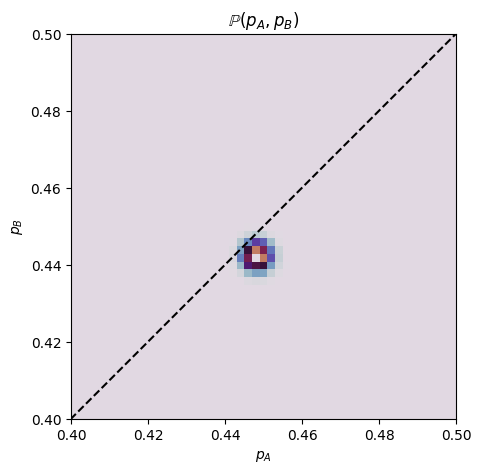

In [25]:
cmap = "twilight"

xedges = np.linspace(0,1,500)
yedges = np.linspace(0,1,500)
H, xedges, yedges = np.histogram2d(control_p, test_p, bins=(xedges, yedges))
H = H.T

fig = plt.figure(figsize=(7, 5))
plt.imshow(H, interpolation='nearest',origin='lower',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],cmap=cmap)
plt.plot([0,1],[0,1],'--k')
plt.xlabel(r'$p_A$')
plt.ylabel(r'$p_B$')
plt.title(r'$\mathbb{P}(p_A,p_B)$')
plt.xlim([0.4, 0.5])
plt.ylim([0.4, 0.5])

plt.show()

In [26]:
print(np.mean(control_p < test_p), np.mean(test_p - control_p))

0.0383 -0.0058726244877544435


0.0011 -0.04276915970611291


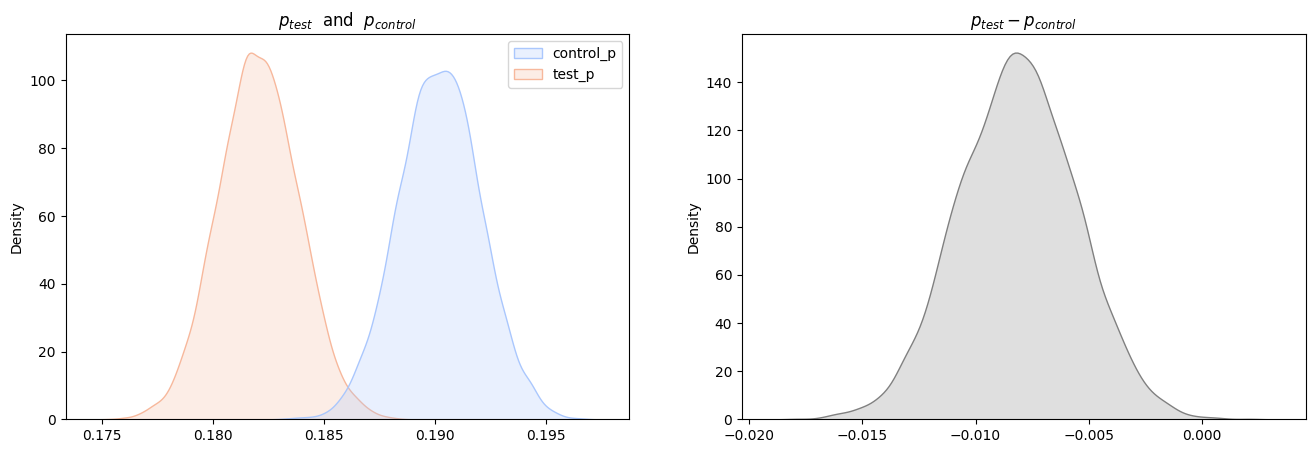

In [27]:
np.random.seed(42)
control_p = st.beta(1 + control['retention_7'].sum(), 1 + (control['retention_7'].count() - control['retention_7'].sum())).rvs(10000)
test_p = st.beta(1 + test['retention_7'].sum(), 1 + (test['retention_7'].count() - test['retention_7'].sum())).rvs(10000)

fg = {
    'control_p': control_p,
    'test_p': test_p
}

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 5))
_ = sns.kdeplot(fg, fill=True, ax=ax1, palette = "coolwarm").set_title(r'$p_{test}$  and  $p_{control}$')
_ = sns.kdeplot(test_p - control_p, fill=True, ax=ax2, color="grey").set_title(r'$p_{test}-p_{control}$')

print(np.mean(control_p < test_p), np.mean((test_p - control_p) / control_p))

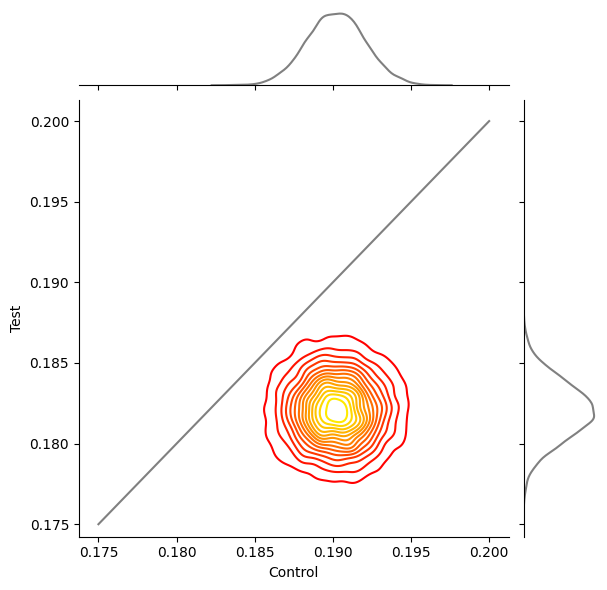

0.0011 -0.008152441813818953


In [28]:
vals=np.vstack([control_p, test_p]).T

ct=pd.DataFrame(vals, columns=['Control', 'Test'])
g=sns.jointplot(x=ct.Control, y=ct.Test, kind='kde', n_levels=15, color="grey", cmap="autumn")
g.ax_joint.plot([0.175, 0.2], [0.175, 0.2], color="grey")
plt.show()
print(np.mean(control_p < test_p), np.mean(test_p - control_p))

In [29]:
from tqdm import tqdm
def bayas__prop(sample_a, sample_b, alpha):
    p_a = st.beta(sum(sample_a) + 1, len(sample_a) - sum(sample_a) + 1).rvs(10000)
    p_b = st.beta(sum(sample_b) + 1, len(sample_b) - sum(sample_b) + 1).rvs(10000)
    
    if np.mean(p_b > p_a) > 1 - alpha:
        return True
    else:
        return False

In [32]:
def twoSampZ(sample_a, sample_b, alpha):
    p_a, p_b = np.mean(sample_a), np.mean(sample_b)
    n_a, n_b = len(sample_a), len(sample_b)

    pooledSE = np.sqrt((p_a * (1 - p_a)) / n_a + (p_b * (1 - p_b)) / n_b)
    z = (p_b - p_a) / pooledSE

    pval = st.norm.sf(z)

    if pval < alpha:
        return True, pval
    else:
        return False, pval


In [34]:
twoSampZ(test['retention_1'], control['retention_1'], 0.05)

(True, 0.036959482213435285)

## Decision rule PP2B

### FPR comparison

In [70]:
import statsmodels.stats.api as sms

true_p = 0.2
sample_size = 1000
alpha = 0.05
num_exp = 10 ** 3
bayes_exps = np.zeros(num_exp)
z_exps = np.zeros(num_exp)

for exp in tqdm(range(num_exp)):
    sample_a = st.bernoulli(true_p).rvs(sample_size)
    sample_b = st.bernoulli(true_p).rvs(sample_size)
    bayes_exps[exp] = bayas__prop(sample_a, sample_b, alpha)
    z_exps[exp] = twoSampZ(sample_a, sample_b, alpha)[0]

fnr_a, fnr_b = sms.DescrStatsW(bayes_exps), sms.DescrStatsW(z_exps)
print(f'CI fpr bayes: {fnr_a.tconfint_mean()} \nCI fpr classique: {fnr_b.tconfint_mean()}')

100%|██████████| 1000/1000 [00:05<00:00, 170.15it/s]

CI fpr bayes: (0.04702768003094833, 0.07697231996905167) 
CI fpr classique: (0.04702768003094833, 0.07697231996905167)


### Power comparison

In [68]:
true_p = 0.2
sample_size = 1000
alpha = 0.05
num_exp = 10 ** 3
bayes_exps = np.zeros(num_exp)
z_exps = np.zeros(num_exp)

for exp in tqdm(range(num_exp)):
    sample_a = st.bernoulli(true_p).rvs(sample_size)
    sample_b = st.bernoulli(true_p * 1.05).rvs(sample_size)
    bayes_exps[exp] = bayas__prop(sample_a, sample_b, alpha)
    z_exps[exp] = twoSampZ(sample_a, sample_b, alpha)[0]

power_a, power_b = sms.DescrStatsW(bayes_exps), sms.DescrStatsW(z_exps)
print(f'CI power bayes: {power_a.tconfint_mean()} \nCI power classique: {power_b.tconfint_mean()}')

100%|██████████| 1000/1000 [00:05<00:00, 168.67it/s]

CI power bayes: (0.12126546938531299, 0.16473453061468699) 
CI power classique: (0.12220233548296255, 0.16579766451703742)
